# Preprocess phase 2 data: module-wise collected data

In [1]:
%reload_ext autoreload
# for auto reloading modules without kernel restart
# If this does not work to import custom modules, then restart kernel

In [2]:
# increase default window size for notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

/tmp/ipykernel_11251/696421802.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import timeit
from dataclasses import dataclass       # C like structure
import glob                             # finds all the pathnames matching specified pattern
import datetime as dt
import random
!python --version
print('pandas version: ' + pd.__version__)
print('numpy version: ' + np.__version__)

Python 3.9.7
pandas version: 1.4.1
numpy version: 1.21.2


In [4]:
import sys, os
cwd = sys.path[0]
sys.path.append(os.path.join(cwd, 'my_modules'))                # sys.path[0] is dir of the ipynb file
import custom_plot
import data_clean
import data_preprocess
import constants
import data_clean_phase2

imported custom_plot.py
data_clean imported
data_preprocess imported


In [5]:
%matplotlib notebook
# Plot related packages,%matplotlib notebook makes plots in jupyter interactive

## Each module contains data from 12 cells that constitutes that module, there are a total of 8 battery modules
1. Put all module 1 csv data files under /csv/module1 folder, all module 2 files under /csv/module1 and so on until module 8
2. Modulewise division because sampling rate of one module can be different from other modules
3. Also, each module handles temperature sensors separately, so separating modules give better data

### For all modules: read from CSV, drop duplicates, sort with timestamp and save as data frames

In [9]:
PHASE2_PATH = os.path.join(cwd, 'csv', 'phase_2_pkl')     # save path for phase 2 processed pickle dataframes

In [12]:
for i in range(1, constants.NUM_MODULES + 1):
    path = r'csv/module_' + str(i) # path for module 1
    df = data_clean_phase2.csv_to_df(path)
    src = os.path.join(PHASE2_PATH, 'module_' + str(i) + '_sorted.pkl')
    print(i, src, len(df))
    df.to_pickle(src)
    df = None   # empty the df

1 /media/avt/development/ME_dev/battery_aging_algo/csv/phase_2_pkl/module_1_sorted.pkl 4257220
2 /media/avt/development/ME_dev/battery_aging_algo/csv/phase_2_pkl/module_2_sorted.pkl 4257221
3 /media/avt/development/ME_dev/battery_aging_algo/csv/phase_2_pkl/module_3_sorted.pkl 4257221
4 /media/avt/development/ME_dev/battery_aging_algo/csv/phase_2_pkl/module_4_sorted.pkl 4257221
5 /media/avt/development/ME_dev/battery_aging_algo/csv/phase_2_pkl/module_5_sorted.pkl 4257220
6 /media/avt/development/ME_dev/battery_aging_algo/csv/phase_2_pkl/module_6_sorted.pkl 4257219
7 /media/avt/development/ME_dev/battery_aging_algo/csv/phase_2_pkl/module_7_sorted.pkl 4257219
8 /media/avt/development/ME_dev/battery_aging_algo/csv/phase_2_pkl/module_8_sorted.pkl 4257219


### Load df data and test whether they are valid

In [29]:
# Test if no duplicates and increasing
for i in range(1, constants.NUM_MODULES + 1):
    df_mod1 = pd.read_pickle(PHASE2_PATH + '/module_' + str(i) + '_sorted.pkl')
    print(df['timestamp'].is_monotonic_increasing)
    print('rows, cols', df.shape)
    print(df.columns)
    break

True
rows, cols (4257220, 18)
Index(['timestamp', 'current', 'contactor_state', 'min_SOC', 'V1', 'V2', 'V3',
       'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'Temp_mean',
       'time_group'],
      dtype='object')


In [30]:
# Change column names, remove the can id from the begining
# print(df.columns)

df_mod1.rename(columns = {
    '10.current_bms01':'current',
    '20.stringvoltage_bms01':'string_V',
    '740.minsoc_bms01':'min_SOC',
    '40.minsoh_bms01':'min_SOH',
    '3c0.currentmodule1integral_bms01':'cur_integral_module1',
    '3c0.currentmodule1_bms01':'cur_module1',
    '6c0.contactorstate_bms01':'contactor_state',
    '740.ctrofftime_bms01':'contactor_off_time',
    '7c0.brickvoltage001_bms01':'V1',
    '7c0.brickvoltage002_bms01':'V2',
    '7c0.brickvoltage003_bms01':'V3',
    '7c0.brickvoltage004_bms01':'V4',
    '7c0.brickvoltage005_bms01':'V5',
    '7c0.brickvoltage006_bms01':'V6',
    '7c0.brickvoltage007_bms01':'V7',
    '7c0.brickvoltage008_bms01':'V8',
    '7c0.brickvoltage009_bms01':'V9',
    '7c0.brickvoltage010_bms01':'V10',
    '7c0.brickvoltage011_bms01':'V11',
    '7c0.brickvoltage012_bms01':'V12',
    '7c0.moduletemperature01_bms01':'T1',
    '7c0.moduletemperature02_bms01':'T2',
    '7c0.moduletemperature03_bms01':'T3',
    '7c0.moduletemperature04_bms01':'T4',
    }, inplace = True)



In [31]:
# average module temp is only necessary
df_mod1['Temp_mean'] = df_mod1[['T1', 'T2', 'T3', 'T4']].mean(axis=1)

In [32]:
# remove all unnecessary columns
df_mod1.drop(['T1', 'T2', 'T3', 'T4', 'string_V', '30.minsoc_bms01', 'min_SOH', 'cur_integral_module1',
        'cur_module1', '3c0.currentmodule2integral_bms01', '3c0.currentmodule2_bms01', 
         '3c0.currentmodule3_bms01', '740.sococvinit_bms01', 'contactor_off_time',
         '740.lifetime_bms01', '740.sleeptime_bms01', '780.bmsonboardtemperature_bms01',
         '780.cmbonboardtemperature01_bms01', '740.invalidmoduletempflags_bms01', 
         '740.invalidmodulevoltageflags_bms01', '3c0.currentmodule3integral_bms01'], axis=1, inplace=True)

In [33]:
# Remove SNA voltages i.e. interpolate voltages where they are out of limit, also for current

NUM_CELLS_MODULE_1 = 12
for i in range(1, NUM_CELLS_MODULE_1 + 1):   # The voltage columns are V1, V2, ..., V96
    df_mod1_processed = data_preprocess.interpolate_beyond_limit(df_mod1, 'V'+str(i), constants.VOLTAGE_LOWER_LIMIT, constants.VOLTAGE_UPPER_LIMIT)
df = data_preprocess.interpolate_beyond_limit(df_mod1_processed, 'current', constants.CURRENT_LOWER_LIMIT, constants.CURRENT_UPPER_LIMIT)

In [34]:
# test whether SNA removal was successful
col_cur = df["current"].copy()
col_volt = df["V1"].copy()
max_cur = col_cur.max()
min_cur = col_cur.min()
max_volt = col_volt.max()
min_volt = col_volt.min()
print(min_cur, max_cur, max_volt, min_volt)
print('rows, cols: ', df.shape)

-274.2 139.3 4.1526 3.2431
rows, cols:  (4257220, 17)


In [35]:
# Fill NAN values
if (df['contactor_state'].isnull().sum() > 0) or (df['current'].isnull().sum() > 0) or (df['V1'].isnull().sum() > 0):
    df.fillna(method="ffill", inplace=True)

### Save renamed module 1 data

In [36]:
# Save df with average temperature
dir_path = os.path.join(cwd, 'csv', 'phase_2_pkl')
src_path = os.path.join(dir_path, 'module1_cleaned.pkl')

df.to_pickle(src_path)

### Load clean data, start from here

In [37]:
# load last saved df and convert time stamp and sort
path = os.path.join(sys.path[0], 'csv/phase_2_pkl')
df = pd.read_pickle(path + '/module1_cleaned.pkl')
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S')
df = df.sort_values(by='timestamp')
df['timestamp'] = df['timestamp'].dt.tz_localize(None)          # remove UTC parts

In [38]:
tu_time_divided_ts = data_preprocess.get_ts_records_by_timegap(df, 'timestamp', 1) # rets tuple of dfs
print(len(tu_time_divided_ts))          # length 1259

1259


In [39]:
# get sequence that have both contactor on and off
li_ts_segments = data_preprocess.get_continuous_ts_segments_list(tu_time_divided_ts)
li_ts_segments = [data_preprocess.add_elapsed_sec(each_df, 'timestamp') for each_df in li_ts_segments] # Add elapsed time for plotting and other reasons

In [85]:
# test
# li_ts_segments[5]['timestamp'].is_monotonic_increasing
print(len(li_ts_segments))

212


<IPython.core.display.Javascript object>


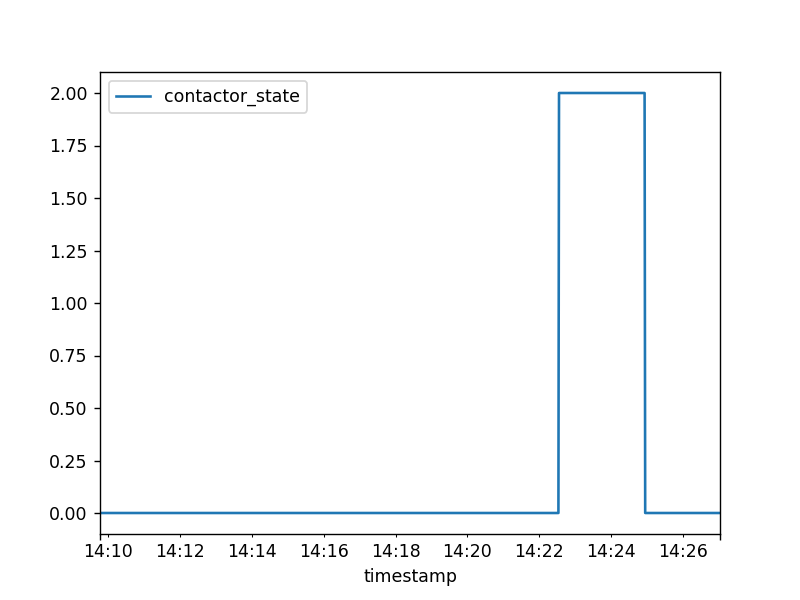

In [88]:
# test for testing Static_dynamic_static algorithm
%matplotlib notebook
df_temp = li_ts_segments[113].copy()
df_temp.plot(x ='timestamp', y='contactor_state', kind = 'line')
plt.show()

In [89]:
# insert dfs into a list
li_full_cycle = []           # each element is a df containing a ful cycle in sequence: static + dynamic + static
for i in range(len(li_ts_segments)):
    df_temp = li_ts_segments[i].copy()
    li_full_cycle += data_preprocess.get_full_cycles_list(df_temp, 'contactor_state', 'timestamp')

print(len(li_full_cycle))

3


<IPython.core.display.Javascript object>


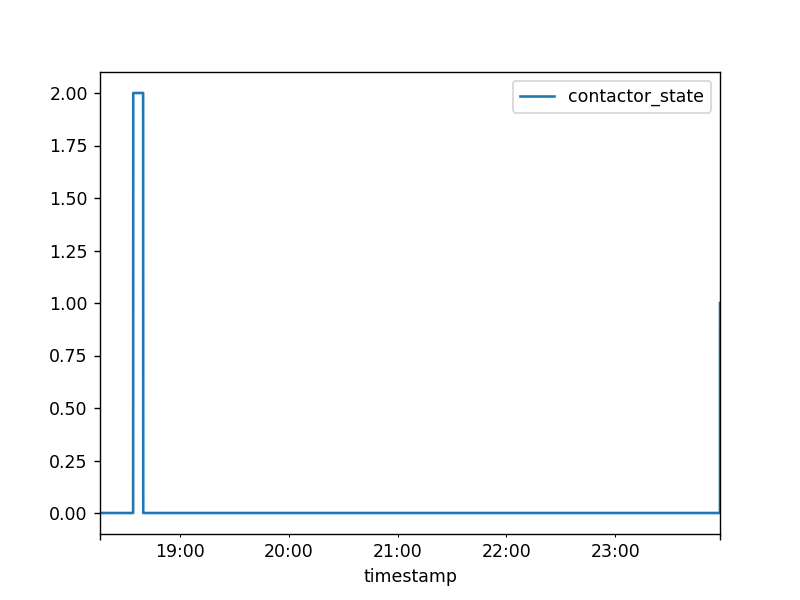

In [92]:
# test for testing Static_dynamic_static algorithm
%matplotlib notebook
df_temp = li_full_cycle[2].copy()
df_temp.plot(x ='timestamp', y='contactor_state', kind = 'line')
plt.show()

In [93]:
NUM_CELLS_MODULE_1 = 12
li_cells_valid_cycles = []
for i in range(1, NUM_CELLS_MODULE_1 + 1):
    li_cells_valid_cycles.append(data_preprocess.get_valid_cycles_list(li_full_cycle, 'V'+str(i), 'timestamp'))

# Check how many valid data points
sum_ts = 0
print('total cells: ', len(li_cells_valid_cycles))
for i in range(NUM_CELLS_MODULE_1):
    print('cell ', i+1, ' has ', len(li_cells_valid_cycles[i]), ' cycles')
    sum_ts += len(li_cells_valid_cycles[i])
print('Total number of cycles: ', sum_ts)

total cells:  12
cell  1  has  1  cycles
cell  2  has  1  cycles
cell  3  has  1  cycles
cell  4  has  1  cycles
cell  5  has  1  cycles
cell  6  has  1  cycles
cell  7  has  1  cycles
cell  8  has  1  cycles
cell  9  has  1  cycles
cell  10  has  1  cycles
cell  11  has  1  cycles
cell  12  has  1  cycles
Total number of cycles:  12


In [96]:
# Filter cycles that have constant voltage or current throughout the entire time line
# Remove unrelated voltages from li_cells_valid_cycles

li_cell_cycles = []          # each element contains (voltage_cellno, ValidCycles) where ValidCycles=[valid_cycles] for that cell
li_cycle_df = []
for i in range(len(li_cells_valid_cycles)):
    cell_id = i + 1
    
    if(1 <= cell_id <= 12):
        col_temp = 'Temp_mean'

    li_cellx_cycles = li_cells_valid_cycles[i]
    for df_x in li_cellx_cycles:
        df_temp = df_x.copy()
        # print(df_temp)
        if(data_preprocess.is_unique(df_temp['V'+str(cell_id)]) or data_preprocess.is_unique(df_temp['current'])):
            # all voltages are same, or all current values are same, do not append
            pass
        else:
            # keep minimum columns and append to cycle list
            voltage_cellno = 'V' + str(cell_id)
            df_temp = df_temp[['timestamp', 'current', 'min_SOC', 'contactor_state', 
                 voltage_cellno, col_temp]]
            df_temp = data_preprocess.add_elapsed_sec(df_temp, 'timestamp')
            df_temp.rename(columns = {voltage_cellno:'V', col_temp:'Temp'}, inplace = True)
            # append tuple of (voltage_cellno, ValidCycles) as each element
            li_cycle_df.append(df_temp)
    
    # append to outer list
    li_cell_cycles.append((voltage_cellno, li_cycle_df))
    li_cycle_df = []      # initialize inner cycle list


In [97]:
print(len(li_cell_cycles))

12


### Save cell_cycles for module 1

In [98]:
# Save list as pkl checkpoint
import pickle
dir_path = os.path.join(cwd, 'csv', 'phase_2_pkl')
src_path = os.path.join(dir_path, 'mod1_cell_cycles.pkl')

with open(src_path, 'wb') as f:
    pickle.dump(li_cell_cycles, f)

In [ ]:
# Sayan broadband stat
def calc_feature(signal,feature):
    if feature == "power":
        coefficient = 20 * np.log10(np.std(signal) / 2e-5)
    elif feature == "crest":
        rms = np.sqrt(np.mean(np.square(signal)))
        coefficient = max(signal) / rms
    elif feature == "shape":
        rms = np.sqrt(np.mean(np.square(signal)))
        coefficient = rms / np.mean(abs(signal))
    elif feature == "rms":
        coefficient = np.sqrt(np.mean(np.square(signal)))
    elif feature == "var":
        coefficient = np.var(signal)
    elif feature == "skewness":
        coefficient =  skew(signal)
    elif feature == "kurtosis":
        coefficient = kurtosis(signal)
    return coefficient
